## 3. K-means

### 3.1. 개요

  - K-평균 알고리즘(K-means algorithm)은 주어진 데이터를 k개의 클러스터로 묶는 방법으로 각 클러스터와의 거리 차이 분산을 최소화
  - 본 알고리즘은 비지도학습(Unsupervised Learning)의 일종으로, 레이블이 없는 입력 데이터에 레이블을 달아주는 역할을 수행
  - K-평균 알고리즘은 공간데이터 분석(물류센터 위치선정), 웹문서 분류 등 다양한 분야 에서 이용
  - (위키피디아)

  <img src = "images/image15.png">

### 3.2. K-means 알고리즘

  - Assignment step 과 update step 으로 구성
  - Assignment step 에서는 점(point)으로부터 각 클러스터의 중심점까지의 직선 거리를 계산하고, 그 점에서 가장 가까운 클러스터를
찾아 점을 배당
  -  Update step 에서는 각 클러스터에 있는 점들의 무게중심 값으로 해당 클러스터의 중심위치를 재설정. 
  -  클러스터의 중심위치가 변하지 않을 때까지 반복
  
  <img src = "images/image16.png">

1. Scipy 함수를 이용하여 데이터 생성

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

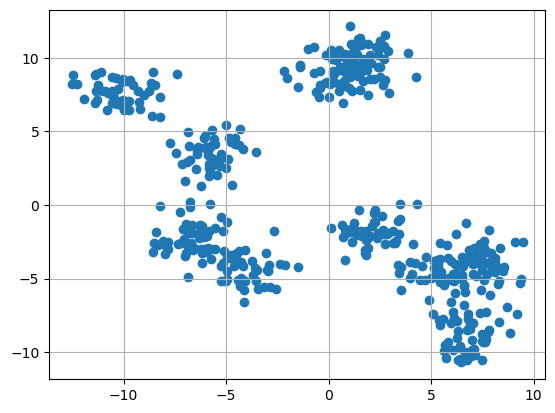

In [3]:
X,y = make_blobs(n_samples = 500,n_features = 2,centers = 10,random_state = 23)

np.save("X", X)
np.save("y", y)

fig = plt.figure(0)
plt.grid(True)
plt.scatter(X[:,0], X[:,1])
plt.show()


2. 순차코드
  - 7개로 생성된 클러스터를 분류
  - 초기 무게중심 값은 (-10, 10) 사에에서,랜덤하게 생성

In [ ]:
k = 7
 
clusters = {}
np.random.seed(23)
 
for idx in range(k):
    center = 10*(2*np.random.random((X.shape[1],))-1)
    points = []
    cluster = {
        'center' : center,
        'points' : []
    }
     
    clusters[idx] = cluster
     
clusters

In [ ]:
def distance(p1,p2):
    return np.sqrt(np.sum((p1-p2)**2))

#Implementing E step 
def assign_clusters(X, clusters):
    for idx in range(X.shape[0]):
        dist = []
         
        curr_x = X[idx]
         
        for i in range(k):
            dis = distance(curr_x,clusters[i]['center'])
            dist.append(dis)
        curr_cluster = np.argmin(dist)
        clusters[curr_cluster]['points'].append(curr_x)
    return clusters
         
#Implementing the M-Step
def update_clusters(X, clusters):
    for i in range(k):
        points = np.array(clusters[i]['points'])
        if points.shape[0] > 0:
            new_center = points.mean(axis =0)
            clusters[i]['center'] = new_center
             
            clusters[i]['points'] = []
    return clusters

def pred_cluster(X, clusters):
    pred = []
    for i in range(X.shape[0]):
        dist = []
        for j in range(k):
            dist.append(distance(X[i],clusters[j]['center']))
        pred.append(np.argmin(dist))
    return pred

for i in range (10) :
    clusters = assign_clusters(X,clusters)
    clusters = update_clusters(X,clusters)
    pred = pred_cluster(X,clusters)

    print(clusters)

plt.scatter(X[:,0],X[:,1],c = pred)
for i in clusters:
    center = clusters[i]['center']
    plt.scatter(center[0],center[1],marker = '^',c = 'red')
plt.show()

3. 병렬코드
  - 의존성 분석
    - 각 점의 거리계산은 독립적임
    - 거리계산으로부터 무게중심 계산시 reduction 연산이 필요
    - 출력을 위해 각 프로세스의 결과를 gather

In [ ]:
%%writefile KM.py
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
from sklearn.datasets import make_blobs
from tools import para_range

def distance(p1,p2):
    return np.sqrt(np.sum((p1-p2)**2))

#Implementing E step 
def assign_clusters(X, clusters):
    for idx in range(X.shape[0]):
        dist = []
         
        curr_x = X[idx]
         
        for i in range(k):
            dis = distance(curr_x,clusters[i]['center'])
            dist.append(dis)
        curr_cluster = np.argmin(dist)
        clusters[curr_cluster]['points'].append(curr_x)
    return clusters
         
#Implementing the M-Step
def update_clusters(X, clusters):
    for i in range(k):
        points = np.array(clusters[i]['points'])
        local_sums = points.sum(axis = 0)
        ##### Local sum의 reduction 필요.
        n_points = #FIX ME
        coords_sums = #FIX ME

        if n_points > 0:
            new_center = coords_sums / n_points
            clusters[i]['center'] = new_center             
            clusters[i]['points'] = []

    return clusters

def pred_cluster(X, clusters):
    pred = []
    for i in range(X.shape[0]):
        dist = []
        for j in range(k):
            dist.append(distance(X[i],clusters[j]['center']))
        pred.append(np.argmin(dist))
    return pred

comm = MPI.COMM_WORLD

rank = comm.Get_rank()
size = comm.Get_size()

n = 500
k = 7

if rank == 0 :

    X = np.load("X.npy")
    y = np.load("y.npy")
    
    fig = plt.figure(0)
    plt.grid(True)
    plt.scatter(X[:,0], X[:,1])
    plt.show()

else : 
    X = np.empty((0, 0), dtype = np.float64)

clusters = {}
np.random.seed(23)

for idx in range(k):
    center = 10*(2*np.random.random((2,))-1)
    points = []
    cluster = {
        'center' : center,
        'points' : []
    }
    
    clusters[idx] = cluster

ista, iend = para_range(n, size, rank)

chunk = iend - ista + 1

X_chunk = np.empty([chunk,2], np.float64)

chunk_cnts = comm.allgather(chunk*2)

##### 데이터를 chunk로 분할. cluster 정보는 공유 (데이터 양이 크지 않음)
comm.Scatterv #FIX ME
comm.bcast(clusters, root = 0)

for i in range (10) :
    clusters = assign_clusters(X_chunk, clusters)
    clusters = update_clusters(X_chunk,clusters)
    pred = pred_cluster(X_chunk,clusters)

    if rank == 0 :
        print(clusters)

##### prediction gather
pred_all = comm.gather #FIX ME

if rank == 0 :
    plt.figure(1)
    plt.scatter(X[:,0],X[:,1], c = pred_all)
    for i in clusters:
        center = clusters[i]['center']
        plt.scatter(center[0],center[1],marker = '^',c = 'red')
    plt.show()

In [ ]:
! mpirun -np 4 python KM.py